In [1]:
import os
import numpy as np
import pandas as pd
import uproot as ur

import matplotlib.pyplot as plt
from IPython.display import display, HTML

%matplotlib inline
import time

pd.set_option('display.max_columns', 100)  # to see more columns of df.head()
np.random.seed(31415)  # set the np random seed for the reproducibility

# some utilities
from math import sqrt
from math import log

In [2]:
import xgboost

print(xgboost.__version__)  # Tested with 1.6.1, version above 1 is recommended.
import lightgbm

print(lightgbm.__version__)  # Tested with 2.2.3
import sklearn

print(sklearn.__version__)  # Tested with 1.0.2

2.1.1
4.5.0
1.5.1


In [3]:
filename = "0.02M_BDT_htta_signal_bg_6800_output.root"
file = ur.open(filename)
print(file.classnames())

{'htt-BackgroundTree-0.02M;1': 'TTree', 'tt-BackgroundTree-0.02M;1': 'TTree', 'zz-BackgroundTree-0.02M;1': 'TTree', 'ww-BackgroundTree-0.02M;1': 'TTree', 'wz-BackgroundTree-0.02M;1': 'TTree', 'ttbb-BackgroundTree-0.02M;1': 'TTree', 'ttjj-BackgroundTree-0.02M;1': 'TTree', 'wwbb-BackgroundTree-0.02M;1': 'TTree', 'zzw-BackgroundTree-0.02M;1': 'TTree', 'tta-BackgroundTree-0.02M;1': 'TTree', 'zzz-BackgroundTree-0.02M;1': 'TTree', 'www-BackgroundTree-0.02M;1': 'TTree', 'zww-BackgroundTree-0.02M;1': 'TTree', 'twhb-BackgroundTree-0.02M;1': 'TTree', 'zza-BackgroundTree-0.02M;1': 'TTree', 'wwa-BackgroundTree-0.02M;1': 'TTree', 'wza-BackgroundTree-0.02M;1': 'TTree', 'ttbba-BackgroundTree-0.02M;1': 'TTree', 'ttjja-BackgroundTree-0.02M;1': 'TTree', 'wwbba-BackgroundTree-0.02M;1': 'TTree', 'zzza-BackgroundTree-0.02M;1': 'TTree', 'ttza-BackgroundTree-0.02M;1': 'TTree', 'twahb-BackgroundTree-0.02M;1': 'TTree', 'htta-SignalTree-0.05M;1': 'TTree'}


In [4]:
# Define weights for each tree
tree_weights = {
    'htt-BackgroundTree-0.02M;1': 350 * 393 / 20000,  
    'tt-BackgroundTree-0.02M;1': 350 * 511000 / 20000,
    'zz-BackgroundTree-0.02M;1': 350 * 9899 / 20000,
    'ww-BackgroundTree-0.02M;1': 350 * 68480 / 20000,
    'wz-BackgroundTree-0.02M;1': 350 * 26280 / 20000,
    'ttbb-BackgroundTree-0.02M;1': 350 * 15450 / 20000,
    'ttjj-BackgroundTree-0.02M;1': 350 * 481400 / 20000,
    'wwbb-BackgroundTree-0.02M;1': 350 * 597900 / 20000,
    'zzw-BackgroundTree-0.02M;1': 350 * 28.89 / 20000,
    'tta-BackgroundTree-0.02M;1': 350 * 2273 / 20000,
    'zzz-BackgroundTree-0.02M;1': 350 * 9.8 / 20000,
    'www-BackgroundTree-0.02M;1': 350 * 78.5 / 20000,
    'zww-BackgroundTree-0.02M;1': 350 * 89.99 / 20000,
    'twhb-BackgroundTree-0.02M;1': 350 * 903 / 20000,
    'zza-BackgroundTree-0.02M;1': 350 * 43.88 / 20000,
    'wwa-BackgroundTree-0.02M;1': 350 * 282.7 / 20000,
    'wza-BackgroundTree-0.02M;1': 350 * 95.53 / 20000,
    'ttbba-BackgroundTree-0.02M;1': 350 * 72.2 / 20000,
    'ttjja-BackgroundTree-0.02M;1': 350 * 2312 / 20000,
    'wwbba-BackgroundTree-0.02M;1': 350 * 5865 / 20000,
    'zzza-BackgroundTree-0.02M;1': 350 * 0.06577 / 20000,
    'ttza-BackgroundTree-0.02M;1': 350 * 5.123 / 20000,
    'twahb-BackgroundTree-0.02M;1': 350 * 9.26 / 20000,
    'htta-SignalTree-0.05M;1': 350 * 0.1389 / 50000  
}



# Initialize an empty list to store DataFrames
dataframes = []

# Loop through the trees in the ROOT file
for tree_name in file.keys():
    tree = file[tree_name]
    
    # Load the data into a pandas DataFrame
    df = tree.arrays(library="pd")

        # Add the tree name to the DataFrame
    df['tree_name'] = tree_name  # Add this line to include the tree name
    
    # Assign labels: 1 for signal, 0 for background
    if "SignalTree" in tree_name or "htta" in tree_name:  # Adjust this condition based on your signal tree name
        df['label'] = 1  # Signal
        df['mcWeight'] = tree_weights.get(tree_name, 1.0)  # Assign weight for signal
    else:
        df['label'] = 0  # Background
        df['mcWeight'] = tree_weights.get(tree_name, 1.0)  # Assign weight for background


     # Assign labels: 1 for signal, 0 for background
  #  if "SignalTree" in tree_name or "htta" in tree_name:  # Adjust this condition based on your signal tree name
  #      df['label'] = 1  # Signal
  #  else:
  #      df['label'] = 0  # Background       
    
    # Append the DataFrame to the list
    dataframes.append(df)

# Concatenate all DataFrames into a single DataFrame
dfall = pd.concat(dataframes, ignore_index=True)

# Print the number of events loaded
print("Total events loaded:", dfall.shape[0])

# Optionally, display the first few rows of the combined DataFrame
print(dfall.head())

Total events loaded: 510000
      jet1_pt     jet2_pt    jet3_pt    jet4_pt    jet5_pt    jet6_pt  \
0   93.244835   90.718109  59.216011  58.302933  40.726330  39.007057   
1  106.120346  100.469437  90.348785  67.917374  56.572250  55.301636   
2  243.182190  226.750504  79.672356  69.643478  54.953247  53.217770   
3  130.905228   92.677979  54.333149  44.611488  26.562731   0.000000   
4  133.235870  118.585953  85.635345  76.523010  60.519268  59.826458   

     jet7_pt    jet8_pt  numJets  numBJets  numlightJets  numElectrons  \
0   0.000000   0.000000        6         3             3             0   
1  43.793949  35.427143        8         3             5             0   
2  42.327347   0.000000        7         1             6             0   
3   0.000000   0.000000        5         2             3             1   
4  52.518009  42.225193       10         3             7             0   

   numMuons  numPhotons  n_leptons  closest_m_jj_H  second_m_jj_H  \
0         0        

In [5]:
# shuffle the events, already done but just to be safe!
dfall = dfall.sample(frac=1).reset_index(drop=True)
from datetime import datetime

print("now :", datetime.now())
print("File loaded with ", dfall.shape[0], " events ")

now : 2025-06-21 12:45:04.632151
File loaded with  510000  events 


In [6]:
# Assign weights based on the desired counts
#desired_signal_count = 52
#desired_background_count = 6_000_000_000

# Actual counts
#actual_signal_count = 50000
#actual_background_count = 480000

# Calculate weights
#weight_signal = desired_signal_count / actual_signal_count
#weight_background = desired_background_count / actual_background_count

# Assign weights to the DataFrame
#dfall['mcWeight'] = 0
#dfall['mcWeight'] = dfall['mcWeight'].astype(float)
#dfall.loc[dfall['label'] == 1, 'mcWeight'] = weight_signal  # Weight for signal
#dfall.loc[dfall['label'] == 0, 'mcWeight'] = weight_background  # Weight for background

# Check the weights
#print(dfall[['label', 'mcWeight']].head())



# Assign weights to the DataFrame based on the tree_weights dictionary
dfall['mcWeight'] = 0
dfall['mcWeight'] = dfall['mcWeight'].astype(float)

# Assign weights based on the tree name
for tree_name in tree_weights.keys():
    dfall.loc[(dfall['label'] == 1) & (dfall['tree_name'] == tree_name), 'mcWeight'] = tree_weights[tree_name]  # Weight for signal
    dfall.loc[(dfall['label'] == 0) & (dfall['tree_name'] == tree_name), 'mcWeight'] = tree_weights[tree_name]  # Weight for background

# Check the weights
print(dfall[['label', 'mcWeight']].head())

   label    mcWeight
0      0    0.089653
1      0    1.574825
2      0    0.171500
3      0    0.767900
4      0  270.375000


In [7]:
# Check the data types of each column
print(dfall.dtypes)

# Identify columns that are of type 'object'
non_numeric_cols = dfall.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_cols)

jet1_pt           float32
jet2_pt           float32
jet3_pt           float32
jet4_pt           float32
jet5_pt           float32
                   ...   
deltaR56_bjets    float32
higgs_mass        float32
tree_name          object
label               int64
mcWeight          float64
Length: 140, dtype: object
Non-numeric columns: Index(['tree_name'], dtype='object')


In [8]:
# Convert non-numeric columns to numeric, coercing errors to NaN
for col in non_numeric_cols:
    dfall[col] = pd.to_numeric(dfall[col], errors='coerce')

# Optionally, fill NaNs created by coercion
dfall.fillna(0, inplace=True)  # or handle NaNs as appropriate for your analysis

In [9]:
# Check for maximum values in each column
max_values = dfall.max()
print(max_values[max_values > 1e10])  # Adjust the threshold as needed

rat_MET_HT                     inf
deltaEta12_leptons    2.818371e+20
deltaEta_p1_l2        1.718277e+19
deltaR12_leptons      7.268615e+22
deltaR_p1_l2          1.646867e+22
dtype: float64


In [10]:
dfall.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf with NaN
dfall.fillna(0, inplace=True)  # Then handle NaNs as needed

In [11]:
# Define a threshold for capping
threshold = 1e10  # Adjust this threshold based on your understanding of the data

# Cap extreme values in the specified columns
columns_to_cap = ['deltaEta12_leptons', 'deltaEta_p1_l2', 'deltaR12_leptons', 'deltaR_p1_l2']
for col in columns_to_cap:
    dfall[col] = dfall[col].clip(upper=threshold)

In [12]:
label_weights = (dfall[dfall.label == 0].mcWeight.sum(), dfall[dfall.label == 1].mcWeight.sum())
print("sum of label weights  Background, Signal =", label_weights)

label_nevents = (dfall[dfall.label == 0].shape[0], dfall[dfall.label == 1].shape[0])
print("total class number of events B S", label_nevents)

sum of label weights  Background, Signal = (603004828.5695001, 48.615000000000016)
total class number of events B S (460000, 50000)


In [13]:
print("Df shape before selection :", dfall.shape)

# Also only keep events with positive weight. This is in principle wrong.
# Many Data Science tools break given a negative weight.
fulldata = dfall[ (dfall.mcWeight > 0)]


print("Df shape after selection :", fulldata.shape)

Df shape before selection : (510000, 140)
Df shape after selection : (510000, 140)


In [14]:
# WARNING : there should be no selection nor shuffling later on ! (otherwise misalignement)
target = fulldata["label"]
weights = fulldata["mcWeight"]


# for simplicity of the exercise only keep some features
data = pd.DataFrame(fulldata, columns=["third_m_jj_H", 'numJets', "sumPLMPt", 'sumPMJPt', 'numPhotons', 'n_leptons', 'sumP_HTJPt','sumbjet_pt','sumPMlPt','missing_ET','rat_MET_HT','jet1_pt','bjet_Eta' ])

print("Df shape of dataset to be used :", data.shape)
display(data.head())
display(target.head())
display(weights.head())

Df shape of dataset to be used : (510000, 13)


,third_m_jj_H,numJets,sumPLMPt,sumPMJPt,numPhotons,n_leptons,sumP_HTJPt,sumbjet_pt,sumPMlPt,missing_ET,rat_MET_HT,jet1_pt,bjet_Eta
0,113.429207,7,3.077159,3.077159,0,0,1152.309082,359.305969,219.925766,3.077159,0.128198,88.724709,0.109569
1,138.402008,8,23.580408,23.580408,0,0,1045.828857,255.020752,291.474152,23.580408,1.031184,64.444550,0.947075
2,93.666603,7,159.597107,159.597107,0,0,1721.348755,454.111664,566.159912,159.597107,5.440084,49.213310,-0.296290
3,110.024315,9,25.359444,25.359444,0,0,1229.451294,179.658539,460.426544,25.359444,1.022820,111.518547,-1.067173
4,135.678116,7,112.439522,112.439522,0,0,917.183777,112.964378,458.067017,112.439522,5.250562,104.848282,0.635425


0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

0      0.089653
1      1.574825
2      0.171500
3      0.767900
4    270.375000
Name: mcWeight, dtype: float64

In [15]:
label_n_weights = np.zeros(2)
label_sum_weights = np.zeros(2)
label_mean_weights = np.zeros(2)
label_std_weights = np.zeros(2)
label_neff_fraction = np.zeros(2)

for i in range(2):
    label_n_weights[i] = weights[target == i].size
    label_mean_weights[i] = weights[target == i].mean()
    label_std_weights[i] = weights[target == i].std()
    label_sum_weights[i] = weights[target == i].sum()
    label_neff_fraction[i] = 1 / (1 + (label_std_weights[i] / label_mean_weights[i]) ** 2)

print("Weights quantities for background (target==0) and signal (target==1)")
print("Weights sum", label_sum_weights)
print("N events", label_n_weights)
print("Weights mean", label_mean_weights)
print("Weights std", label_std_weights)
print("Weights Neff fraction", label_neff_fraction)

Weights quantities for background (target==0) and signal (target==1)
Weights sum [6.03004829e+08 4.86150000e+01]
N events [460000.  50000.]
Weights mean [1.31088006e+03 9.72300000e-04]
Weights std [3.11142431e+03 3.25263904e-19]
Weights Neff fraction [0.15074578 1.        ]


In [16]:
np.random.seed(31415)

from sklearn.model_selection import train_test_split

train_size = 0.75  # fraction of sample used for training

X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    data, target, weights, train_size=train_size
)

# Reset index for dataseries, not needed for ndarray (X_train, X_test)
# Basically just re-adding the original element indexing from pandas
y_train, y_test, weights_train, weights_test = (
    y_train.reset_index(drop=True),
    y_test.reset_index(drop=True),
    weights_train.reset_index(drop=True),
    weights_test.reset_index(drop=True),
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("weights shape:", weights_train.shape, "\n")

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("weight shape:", weights_test.shape, "\n")

X_train shape: (382500, 13)
y_train shape: (382500,)
weights shape: (382500,) 

X_test shape: (127500, 13)
y_test shape: (127500,)
weight shape: (127500,) 



In [17]:
# Count the number of signal and background events in the training set
n_train_signal = y_train[y_train == 1].shape[0]  # Count of signal events (label == 1)
n_train_background = y_train[y_train == 0].shape[0]  # Count of background events (label == 0)

# Count the number of signal and background events in the testing set
n_test_signal = y_test[y_test == 1].shape[0]  # Count of signal events (label == 1)
n_test_background = y_test[y_test == 0].shape[0]  # Count of background events (label == 0)

# Print the results
print("Training set:")
print(f"Number of signal events: {n_train_signal}")
print(f"Number of background events: {n_train_background}\n")

print("Testing set:")
print(f"Number of signal events: {n_test_signal}")
print(f"Number of background events: {n_test_background}")

Training set:
Number of signal events: 37391
Number of background events: 345109

Testing set:
Number of signal events: 12609
Number of background events: 114891


In [18]:
# not usually needed for BDT but is good practice
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)  # applies the transformation calculated the line above

In [19]:
class_weights_train = (weights_train[y_train == 0].sum(), weights_train[y_train == 1].sum())

for i in range(len(class_weights_train)):  # loop on B then S targets(labels)
    # training dataset: equalize number of background and signal
    weights_train[y_train == i] *= max(class_weights_train) / class_weights_train[i]

    # test dataset : increase test weight to compensate for sampling
    weights_test[y_test == i] *= 1 / (1 - train_size)

print("Weights have been normalised to a given number of proton collision")
print("Orig : total weight sig", weights[target == 1].sum())
print("Orig : total weight bkg", weights[target == 0].sum(), "\n")

print("Test : total weight sig", weights_test[y_test == 1].sum())
print("Test : total weight bkg", weights_test[y_test == 0].sum(), "\n")
print("Train : total weight sig", weights_train[y_train == 1].sum())
print("Train : total weight bkg", weights_train[y_train == 0].sum())

Weights have been normalised to a given number of proton collision
Orig : total weight sig 48.615000000000016
Orig : total weight bkg 603004828.5695001 

Test : total weight sig 49.03892280000001
Test : total weight bkg 602011588.5778365 

Train : total weight sig 452501931.42504084
Train : total weight bkg 452501931.4250409


In [20]:
from math import sqrt
from math import log


def amsasimov(s, b):
    if b <= 0 or s <= 0:
        return 0
    try:
        return sqrt(2 * ((s + b) * log(1 + float(s) / b) - s))
    except ValueError:
        print(1 + float(s) / b)
        print(2 * ((s + b) * log(1 + float(s) / b) - s))
    # return s/sqrt(s+b)


def sigma(s, b):
    if  s <= 0:
        return 0
    try:
        return s/sqrt(s+b)
    except ValueError:
        print(1 + float(s) / b)
        print(2 * ((s + b) * log(1 + float(s) / b) - s))
    # return s/sqrt(s+b)    

Training time: 60.1383855342865
auc test: 0.9926086880763939
auc train: 1.0 

auc test without weights 0.9923935331329663
Z: 16.664402840812254
sigma: 6.512840050066664


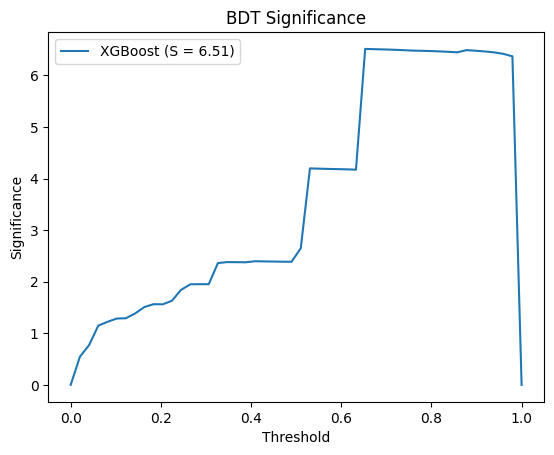

In [21]:
np.random.seed(31415)  # set the random seed

import gc  # Import garbage collection module
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score  # for binary classification if x > 0.5 -> 1 else -> 0

#xgb = XGBClassifier(tree_method="hist", eval_metric='logloss')
# tree_method="hist" is 10 times faster, however less robust against awkwards features (not a bad idea to double check without it)
# can even try tree_method="gpu_hist" if proper GPU installation
# use_label_encoder and eval_metric to silence warning in 1.3.0

# HPO (==Hyper Parameter Optimization), check on the web https://xgboost.readthedocs.io/ for other parameters

# Define the number of estimators
n_estimators = 290

xgb = XGBClassifier(tree_method="hist",max_depth=14,n_estimators=n_estimators)


starting_time = time.time()

xgb.fit(X_train, y_train.values, sample_weight=weights_train.values)  # note that XGB 1.3.X requires positive weight

training_time = time.time() - starting_time
print("Training time:", training_time)

y_pred_xgb = xgb.predict_proba(X_test)[:, 1]
y_pred_xgb = y_pred_xgb.ravel()
y_pred_train_xgb = xgb.predict_proba(X_train)[:, 1].ravel()
auc_test_xgb = roc_auc_score(y_true=y_test, y_score=y_pred_xgb, sample_weight=weights_test)
auc_train_xgb = roc_auc_score(y_true=y_train.values, y_score=y_pred_train_xgb, sample_weight=weights_train)  # Added this line
print("auc test:", auc_test_xgb)
print("auc train:", roc_auc_score(y_true=y_train.values, y_score=y_pred_train_xgb, sample_weight=weights_train), "\n")

print("auc test without weights", roc_auc_score(y_true=y_test, y_score=y_pred_xgb))


# sum S & B after certain thresholds
int_pred_test_sig_xgb = [weights_test[(y_test == 1) & (y_pred_xgb > th_cut)].sum() for th_cut in np.linspace(0, 1, num=50)]
int_pred_test_bkg_xgb = [weights_test[(y_test == 0) & (y_pred_xgb > th_cut)].sum() for th_cut in np.linspace(0, 1, num=50)]

vamsasimov_xgb = [amsasimov(sumsig, sumbkg) for (sumsig, sumbkg) in zip(int_pred_test_sig_xgb, int_pred_test_bkg_xgb)]
significance_xgb = max(vamsasimov_xgb)  # finds the maximum significance. Which threshold results in this significance?
Z = significance_xgb

vsigma_xgb = [sigma(sumsig, sumbkg) for (sumsig, sumbkg) in zip(int_pred_test_sig_xgb, int_pred_test_bkg_xgb)]
significance_sigma_xgb = max(vsigma_xgb)  # finds the maximum significance. Which threshold results in this significance?
S = significance_sigma_xgb

print("Z:", Z)
print("sigma:", S)

# Store n_estimators, Z, and S in a text file
with open("1significance_results.txt", "a") as f:  # Open in append mode
    f.write(f"n_estimators: {n_estimators}, Z: {Z:.8f}, S: {S:.8f}\n")  # Write n_estimators, Z, and S with 4 decimal places


#plt.plot(np.linspace(0, 1, num=50), vamsasimov_xgb, label='XGBoost (Z = {})'.format(np.round(significance_xgb, decimals=2)))

plt.plot(np.linspace(0, 1, num=50), vsigma_xgb, label='XGBoost (S = {})'.format(np.round(significance_sigma_xgb, decimals=2)))


plt.title("BDT Significance")
plt.xlabel("Threshold")
plt.ylabel("Significance")
plt.legend()
# Save the plot with a unique filename
plt.savefig(f"Significance_xgb_n_estimators_{n_estimators}.pdf", dpi=600)  # Use n_estimators for uniqueness
plt.show()

# Explicitly delete variables to free memory
#del y_pred_xgb, y_pred_train_xgb, int_pred_test_sig_xgb, int_pred_test_bkg_xgb, xgb
#gc.collect()  # Force garbage collection
        
#print("All iterations completed.")

In [22]:
np.save("./y_pred_xgb.npy", y_pred_xgb)
np.save("./y_pred_train_xgb.npy", y_pred_train_xgb)
np.save("./weights_train_xgb.npy", weights_train.values)
np.save("./y_test_xgb.npy", y_test)
np.save("./weights_test_xgb.npy", weights_test.values)
xgb.save_model('xgb.model')

/home/kami/miniconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:46:23] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


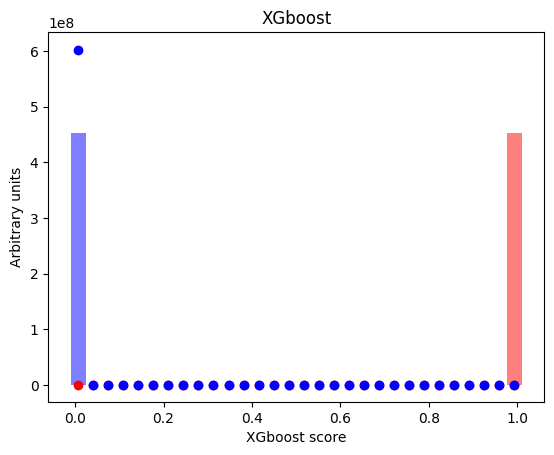

In [30]:
# Plot score for signal and background, comparing training and testing
def compare_train_test(
    y_pred_train,
    y_train,
    y_pred,
    y_test,
    high_low=(-0.01, 1.01),
    bins=30,
    xlabel="",
    ylabel="Arbitrary units",
    title="",
    weights_train=np.array([]),
    weights_test=np.array([]),
    density=False,
):
    if weights_train.size != 0:
        weights_train_signal = weights_train[y_train == 1]
        weights_train_background = weights_train[y_train == 0]
    else:
        weights_train_signal = None
        weights_train_background = None
    plt.hist(
        y_pred_train[y_train == 1],
        color='r',
        alpha=0.5,
        range=high_low,
        bins=bins,
        histtype='stepfilled',
        density=density,
        label='S (train)',
        weights=weights_train_signal,
    )  # alpha is transparancy
    plt.hist(
        y_pred_train[y_train == 0],
        color='b',
        alpha=0.5,
        range=high_low,
        bins=bins,
        histtype='stepfilled',
        density=density,
        label='B (train)',
        weights=weights_train_background,
    )

    if weights_test.size != 0:
        weights_test_signal = weights_test[y_test == 1]
        weights_test_background = weights_test[y_test == 0]
    else:
        weights_test_signal = None
        weights_test_background = None
    hist, bins = np.histogram(y_pred[y_test == 1], bins=bins, range=high_low, density=density, weights=weights_test_signal)
    scale = len(y_pred[y_test == 1]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='S (test)')

    hist, bins = np.histogram(
        y_pred[y_test == 0], bins=bins, range=high_low, density=density, weights=weights_test_background
    )
    scale = len(y_pred[y_test == 0]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='B (test)')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    #plt.legend(loc='best')
compare_train_test(
    y_pred_train_xgb,
    y_train,
    y_pred_xgb,
    y_test,
    xlabel="XGboost score",
    title="XGboost",
    weights_train=weights_train.values,
    weights_test=weights_test.values,
)

#plt.ylim(0, 35)
plt.savefig("1Score_BDT_XGBoost_Hist.png", dpi=600)
plt.savefig("1Score_BDT_XGBoost_Hist.pdf", bbox_inches='tight')

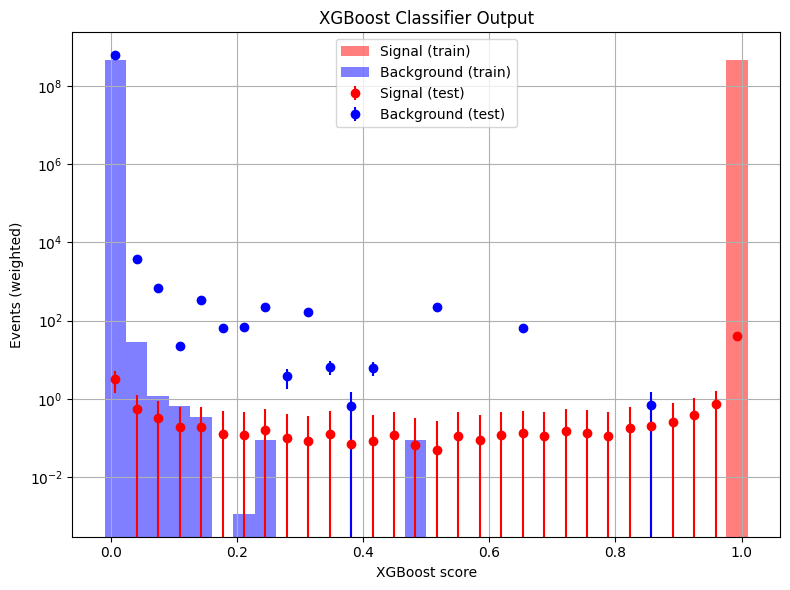

In [32]:
def compare_train_test(
    y_pred_train,
    y_train,
    y_pred,
    y_test,
    high_low=(-0.01, 1.01),
    bins=30,
    xlabel="",
    ylabel="Events (weighted)",
    title="",
    weights_train=np.array([]),
    weights_test=np.array([]),
    density=False,
):
    if weights_train.size != 0:
        weights_train_signal = weights_train[y_train == 1]
        weights_train_background = weights_train[y_train == 0]
    else:
        weights_train_signal = None
        weights_train_background = None

    # Plot training histograms
    plt.hist(
        y_pred_train[y_train == 1],
        color='r',
        alpha=0.5,
        range=high_low,
        bins=bins,
        histtype='stepfilled',
        density=density,
        label='Signal (train)',
        weights=weights_train_signal,
    )
    plt.hist(
        y_pred_train[y_train == 0],
        color='b',
        alpha=0.5,
        range=high_low,
        bins=bins,
        histtype='stepfilled',
        density=density,
        label='Background (train)',
        weights=weights_train_background,
    )

    # Plot test histograms with error bars
    if weights_test.size != 0:
        weights_test_signal = weights_test[y_test == 1]
        weights_test_background = weights_test[y_test == 0]
    else:
        weights_test_signal = None
        weights_test_background = None

    # Signal (test)
    hist_s, bins_s = np.histogram(
        y_pred[y_test == 1], bins=bins, range=high_low, density=density, weights=weights_test_signal
    )
    center_s = (bins_s[:-1] + bins_s[1:]) / 2
    err_s = np.sqrt(hist_s)
    plt.errorbar(center_s, hist_s, yerr=err_s, fmt='o', color='r', label='Signal (test)')

    # Background (test)
    hist_b, bins_b = np.histogram(
        y_pred[y_test == 0], bins=bins, range=high_low, density=density, weights=weights_test_background
    )
    center_b = (bins_b[:-1] + bins_b[1:]) / 2
    err_b = np.sqrt(hist_b)
    plt.errorbar(center_b, hist_b, yerr=err_b, fmt='o', color='b', label='Background (test)')

    plt.yscale("log")  # <-- Log scale
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='best')
    plt.grid()
    plt.tight_layout()

plt.figure(figsize=(8, 6))
compare_train_test(
    y_pred_train_xgb,
    y_train,
    y_pred_xgb,
    y_test,
    xlabel="XGBoost score",
    title="XGBoost Classifier Output",
    weights_train=weights_train.values,
    weights_test=weights_test.values,
)
plt.savefig("1Score_BDT_XGBoost_Hist.png", dpi=600)
plt.savefig("1Score_BDT_XGBoost_Hist.pdf", bbox_inches='tight')
plt.show()


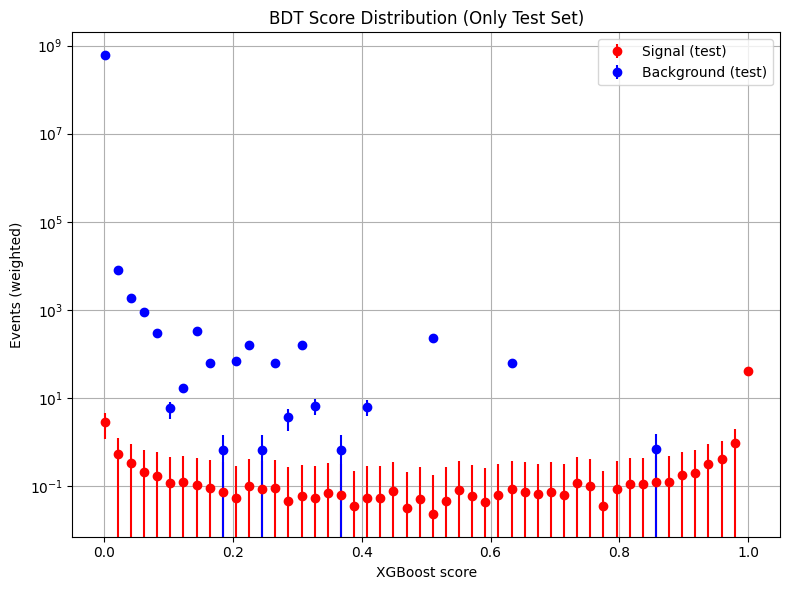

In [34]:
def plot_test_bdt_output(
    y_pred,
    y_test,
    weights_test,
    high_low=(-0.01, 1.01),
    bins=30,
    xlabel="BDT score",
    ylabel="Events (weighted)",
    title="BDT Output (Test Set)"
):
    weights_test_signal = weights_test[y_test == 1]
    weights_test_background = weights_test[y_test == 0]

    # Signal
    hist_s, bins_s = np.histogram(
        y_pred[y_test == 1], bins=bins, range=high_low, weights=weights_test_signal
    )
    center_s = (bins_s[:-1] + bins_s[1:]) / 2
    err_s = np.sqrt(hist_s)
    plt.errorbar(center_s, hist_s, yerr=err_s, fmt='o', color='r', label='Signal (test)')

    # Background
    hist_b, bins_b = np.histogram(
        y_pred[y_test == 0], bins=bins, range=high_low, weights=weights_test_background
    )
    center_b = (bins_b[:-1] + bins_b[1:]) / 2
    err_b = np.sqrt(hist_b)
    plt.errorbar(center_b, hist_b, yerr=err_b, fmt='o', color='b', label='Background (test)')

    plt.yscale("log")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

plt.figure(figsize=(8, 6))
plot_test_bdt_output(
    y_pred_xgb,
    y_test,
    weights_test.values,  # Make sure this is a NumPy array
    bins=50,
    xlabel="XGBoost score",
    title="BDT Score Distribution (Only Test Set)"
)
plt.savefig("1Score_BDT_XGBoost_TestOnly.png", dpi=600)
plt.savefig("1Score_BDT_XGBoost_TestOnly.pdf", bbox_inches='tight')
plt.show()


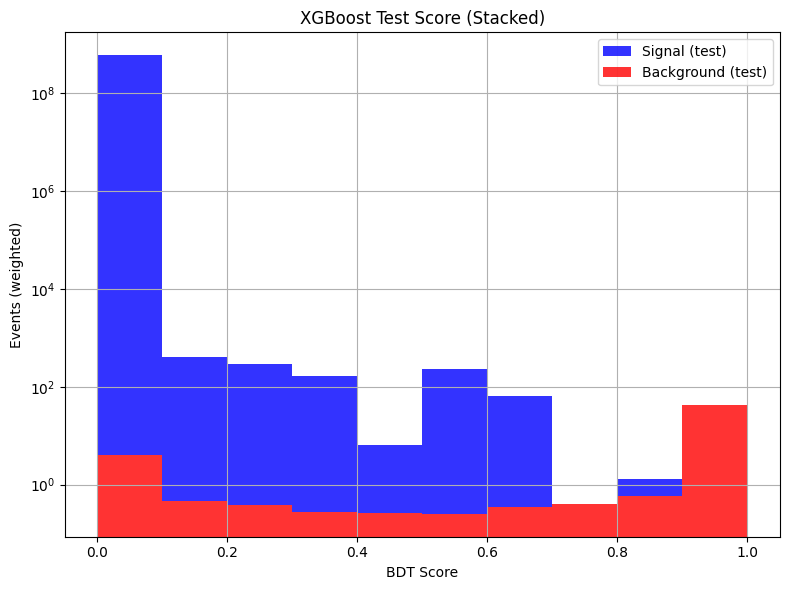

In [43]:
def plot_test_stacked_histogram(
    y_pred,
    y_test,
    weights_test,
    bins=50,
    range=(-1, 1),
    xlabel="BDT score",
    ylabel="Events (weighted)",
    title="XGBoost BDT Score (Test Set Only)"
):
    # Split predictions and weights
    y_sig = y_pred[y_test == 1]
    w_sig = weights_test[y_test == 1]

    y_bkg = y_pred[y_test == 0]
    w_bkg = weights_test[y_test == 0]

    # Plot
    plt.figure(figsize=(8, 6))
    plt.hist(
        [y_sig, y_bkg],
        weights=[w_sig, w_bkg],
        bins=bins,
        range=range,
        color=['r', 'b'],
        label=['Background (test)', 'Signal (test)'],
        stacked=True,
        histtype='stepfilled',
        alpha=0.8
    )
    plt.yscale("log")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("BDT_Test_Stacked.png", dpi=600)
    plt.savefig("BDT_Test_Stacked.pdf", bbox_inches='tight')
    plt.show()

plot_test_stacked_histogram(
    y_pred_xgb,
    y_test,
    weights_test.values,  # Make sure this is a NumPy array
    bins=10,
    range=(0, 1),
    xlabel="BDT Score",
    title="XGBoost Test Score (Stacked)"
)


In [45]:
def plot_test_stacked_histogram_by_category(
    y_pred,
    y_test,
    weights_test,
    df_test,  # ⬅️ DataFrame containing only test set events (must include 'tree_name')
    tree_weights,
    bins=50,
    range=(0, 1),
    xlabel="BDT score",
    ylabel="Events (weighted)",
    title="XGBoost BDT Score (Test Set by Category)"
):
    # Signal (label == 1)
    y_sig = y_pred[y_test == 1]
    w_sig = weights_test[y_test == 1]

    # Background categories
    bg_categories = [k for k in tree_weights.keys() if not ("SignalTree" in k or "htta" in k)]
    bg_colors = plt.cm.tab20(np.linspace(0, 1, len(bg_categories)))
    bg_labels = [cat.split('-')[0] for cat in bg_categories]

    bg_preds = []
    bg_weights = []

    for cat in bg_categories:
        mask = (y_test == 0) & (df_test['tree_name'].values == cat)
        bg_preds.append(y_pred[mask])
        bg_weights.append(weights_test[mask])

    # Plot
    plt.figure(figsize=(10, 8))
    plt.hist(
        [y_sig] + bg_preds,
        weights=[w_sig] + bg_weights,
        bins=bins,
        range=range,
        color=['r'] + list(bg_colors),
        label=['Signal (test)'] + bg_labels,
        stacked=True,
        histtype='stepfilled',
        alpha=0.8
    )
    plt.yscale("log")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='upper right', fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("BDT_Test_Stacked_By_Category.png", dpi=600)
    plt.savefig("BDT_Test_Stacked_By_Category.pdf", bbox_inches='tight')
    plt.show()


In [46]:
plot_test_stacked_histogram_by_category(
    y_pred_xgb,
    y_test,
    weights_test.values,
    df_test,  # ⬅️ must contain only test data and have 'tree_name'
    tree_weights,
    bins=50,
    range=(0, 1),
    xlabel="BDT Score",
    title="XGBoost Test Score (Stacked by Background Category)"
)


NameError: name 'df_test' is not defined